# Sentence encoders: Class imbalance

This notebook investigates some of the approaches that can be taken to class imbalances when using tensorflow sentence encoders on a [Kaggle essay scores](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2) dataset of ~17,000 essays. The strategies explored here include perfectly balanced classes (but with less data), each class having a maximum of x2, x4, and x8 that of the most underepresented class, and including all the data. The model is fit and evaluated on the embeddings for each approach 4 times to obtain more stable accuracy averages. 

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Preprocess text

Common preprocessing steps are applied to simplify the texts and reduce potential noise.

In [2]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):

    # removes unprintable characters
    unprintable = r"[^\w\s]"
    text = re.sub(unprintable, '', text)

    # removes non-breaking space characters
    non_breaking = '\xa0'
    text = re.sub(non_breaking, ' ', text)

    # removes newline characters
    newline = '\n'
    text = re.sub(newline, ' ', text)

    # removes punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # lowercase the text
    text = text.lower()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

## Misspelling function

A misspelling function splits the essay into words and either drops or corrects unknown words.

In [3]:
from spellchecker import SpellChecker

# creates a spellckecker object
spell = SpellChecker()

# returns a count of misspelled words
def misspellings(essay, drop=True):

    # the essay is split into words
    words = essay.split()

    # either drops or corrects unknown words
    final_words = []
    if drop == True:
        # loops through each word
        for word in words:
            
            # checks if the word is known
            if spell.known([word]):
                
                # appends to a list of words to return
                final_words.append(word)
    
    else:
        # loops through each word
        for word in words:
            
            # checks if the word is known
            if spell.known([word]):
                
                # appends to a list of words to return
                final_words.append(word)

            else:
                # attempts to correct the word
                correction = spell.correction(word)

                # appends the correction if one was found
                if correction != None:
                    # appends to a list of words to return
                    final_words.append(correction)

    # joins the words back together with a space 
    return ' '.join(final_words)

## Model functions

The sentence encoder model is first loaded-in. A number of functions are then defined to split the essay texts in into a variable number of words, obtain the embeddings, fit a model and then record accuracy results.

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding
from sklearn.metrics import cohen_kappa_score

# downloads the model to obtain embeddings 
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder_model = hub.load(model_url)

# returns the essay embeddings
def encode_sentences(essays):
    embeddings = encoder_model(essays)
    return embeddings.numpy()

# creates the model
def create_model(embedding_dim):
    model = Sequential([
          Input(shape=(embedding_dim,)),
          Dense(64, activation='relu'),
          Dense(32, activation='relu'),
          Dense(7, activation='softmax')
      ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# fits the model on the training data and evaluates accuracy
def fit_model(embeddings, scores, accuracy_df, class_balance):

    # defines how many times the model should be fit and evaluated to obain a more stable accuracy average
    turns = 4

    # stores each accuracy result in order to obtain an average
    accuracy_scores = []

    # loops through each turn
    for i in range(turns):

        # splits the data into train and validation sets
        x_train, x_val, y_train, y_val = train_test_split(embeddings, scores, test_size=0.3)
    
        # creates and embedding dimension and uses it to create a model
        embedding_dim = embeddings[0].shape[0]
        model = create_model(embedding_dim)
    
        # converts essay scores to one hot encodings
        y_train_one_hot = to_categorical(y_train)
        y_val_one_hot = to_categorical(y_val)
    
        # fits the model
        model.fit(x_train, y_train_one_hot, epochs=12, batch_size=32, validation_data=(x_val, y_val_one_hot)) 
    
        # retrieves predictions 
        predictions = model.predict(x_val)
    
        # converts raw predictions (decimals) into final predictions (1 - 6 integers)
        converted_preds = [np.argmax(pred) for pred in predictions]
        converted_y_val = [np.argmax(y) for y in y_val_one_hot]
    
        # appends rounded Cohen Kappa scores 
        accuracy_scores.append(round(cohen_kappa_score(converted_preds, converted_y_val, weights='quadratic'), 2))
    
    # adds the average accuracy score to the accuracy dataframe
    accuracy_df.loc[0, class_balance] = round(np.mean(accuracy_scores), 2)
    
    return accuracy_df

## Class imbalance

Here the class imalances are addressed. First we list out the value counts for scores. Then we create a series of spliced dataframes, including perfect class balance (with the same number of each scores, 156), reduced class imbalance (with a maximum of x2, x4, and x8 the smallest value count for each class) and all the data.

In [5]:
# lists value counts
train.score.value_counts()

score
3    6280
2    4723
4    3926
1    1252
5     970
6     156
Name: count, dtype: int64

In [6]:
import random

# preprocesses the texts
train['full_text'] = [preprocess_text(x) for x in train['full_text']]

# limits each essay to the first 300 words
texts = [' '.join(x.split()[0:300]) for x in train['full_text']]

# names of different class balance dataframes
class_balances = ['balanced', 'x2', 'x4', 'x8', 'all']

# the different maximum number for each class in the different dataframes
target_nums = [156, 156*2, 156*4, 156*8, np.floor(len(train)/6)]

# selects a specified maxium number of random essays from each score distribution
def splice_df(target_num):
    random_index = []
    for i in range(6):
        num_available = len(train.loc[train.score==i+1])
        if num_available <= target_num:
            target_num = num_available
        random_index.extend( random.sample(list(train.loc[train.score==i+1].index), target_num) )
    return train.loc[random_index].reset_index(drop=True)

# creates a series of dataframes 
lists = {}
for i, class_balance in enumerate(class_balances):
    lists[class_balance] = splice_df(target_nums[i])

## Class imbalance approaches

The relavant class imbalance dataframe is obtained, misspellings dropped, embeddings obtained, model fit and results evaluated.

In [7]:
# creates an accuracy and time dataframe to store results
accuracy_df = pd.DataFrame()

# loops through each class balance
for class_balance in class_balances:

    # defines the relavant dataframe
    texts = lists[class_balance]

    # converts scores to a numpy array for use in the model
    scores = np.array(texts.score)

    # corrects misspellings
    print('Dropping misspellings: ' + class_balance)
    dropped_misspellings = [misspellings(x) for x in texts.full_text]

    # obtains the embeddings
    print('Preparing embeddings: ' + class_balance)
    embeddings = encode_sentences(dropped_misspellings)

    # fits the model 3 times and adds the average accuracy to the accuracy_df
    print('Fitting model: ' + class_balance)
    accuracy_df = fit_model(embeddings, scores, accuracy_df, class_balance)

    # reassigns the embeddings object to nother to conserve memory
    embeddings = ''

Dropping misspellings: balanced
Preparing embeddings: balanced
Fitting model: balanced
Epoch 1/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2319 - loss: 1.9120 - val_accuracy: 0.3345 - val_loss: 1.7923
Epoch 2/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3748 - loss: 1.7193 - val_accuracy: 0.3772 - val_loss: 1.5823
Epoch 3/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3986 - loss: 1.4950 - val_accuracy: 0.4021 - val_loss: 1.4205
Epoch 4/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4819 - loss: 1.3535 - val_accuracy: 0.4413 - val_loss: 1.3316
Epoch 5/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5020 - loss: 1.2622 - val_accuracy: 0.4769 - val_loss: 1.2766
Epoch 6/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5278 - loss: 1.2003 - val_accuracy: 0.4413 - val_loss: 1.2476
Epoch 7/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5648 - loss: 1.1238 - val_accuracy: 0.5160 - val_loss: 1.1987
Epoch 8/12
21/21 ━━━━━━━━━━━━━

## Visualization

The results seem to show that including more balanced classes generally results in greater accuracy.

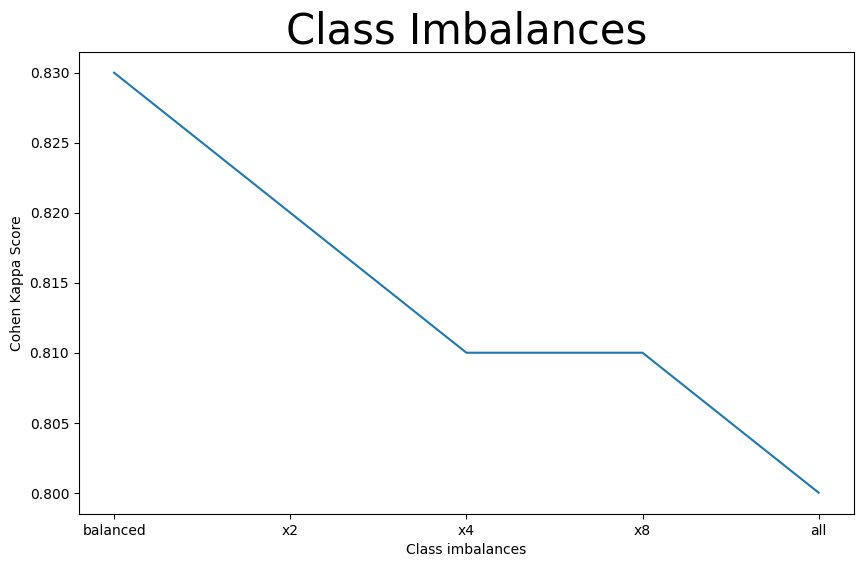

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# transposes the dataframe to get it in the right shape for plotting
accuracy_df = accuracy_df.transpose()

# plots the results as a lineplot in searborn
fig = plt.figure(figsize=(10, 6));
sns.lineplot(x=accuracy_df.index, y=accuracy_df.iloc[:,0], data=accuracy_df);
plt.title('Class Imbalances', size=30);
plt.ylabel('Cohen Kappa Score');
plt.xlabel('Class imbalances');